In [1]:
import sys, os, json, pickle, gzip, copy, torch, numbers, tqdm
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.utils import ActiveElements, MetalElements, Element, AllElements
from src.utils import composit_parser
from src.feature import composition_to_feature

from pymatgen.core import Composition, Element

from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

In [2]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDSM = ReactionGraphDataset(feat_type='cgcnn')
GDSM.from_file('../data/screened_single_source_conditional_reaction.pkl.gz', 
               heat_temp_key=('heat_temp','median'),
               heat_time_key=('heat_time','median'))

In [221]:
years = np.array([d.year for d in GDSM])
test_idx = np.where(years > 2017)[0]
train_idx = np.where(years <= 2017)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=1024, sampler=test_idx, collate_fn=GDSM.cfn)

In [193]:
import gpytorch

class SingleGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.shape[0])
        variational_strategy = gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

_feat, _ = next(iter(train_dl))
model = SingleGPModel(_feat['target_feat']).to('cuda')
likelihood = gpytorch.likelihoods.GaussianLikelihood().to('cuda')


mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_idx))
opt = torch.optim.AdamW([{'params':model.parameters(), 'params':likelihood.parameters()}], lr=.1)

for i in range(20):
    train_loss = 0
    model.train()
    likelihood.train()

    for batch, info in train_dl:
        X = batch['target_feat'].to('cuda')
        Y = batch['condition_feat'][:, 0].to('cuda')
        opt.zero_grad()
        out = model(X)
        loss = -mll(out, Y)
        loss.backward()
        opt.step()
        train_loss += loss.detach().cpu().item()

    model.eval()
    likelihood.eval()
    errs = []
    test_loss = 0
    with torch.no_grad():
        for batch, info in test_dl:
            X = batch['target_feat'].to('cuda')
            Y = batch['condition_feat'][:, 0].to('cuda')

            pred = model(X)
            test_loss += -mll(pred, Y).cpu().item()

            err = pred.mean.cpu() - Y.cpu()
            errs.append(err.numpy())
    
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(
        i, train_loss / len(train_dl), test_loss / len(test_dl), np.abs(np.hstack(errs)).mean()))

  0      1.33521      1.34060      0.33752
  1      1.33401      1.34060      0.33752
  2      1.33399      1.34054      0.33752
  3      1.33398      1.34054      0.33752
  4      1.33400      1.34050      0.33752
  5      1.33397      1.34049      0.33752
  6      1.33399      1.34058      0.33752
  7      1.33399      1.34056      0.33752
  8      1.33399      1.34053      0.33752
  9      1.33398      1.34049      0.33752
 10      1.33399      1.34053      0.33752
 11      1.33398      1.34050      0.33752
 12      1.33397      1.34060      0.33752
 13      1.33399      1.34056      0.33752
 14      1.33400      1.34057      0.33752
 15      1.33401      1.34048      0.33752
 16      1.33404      1.34049      0.33752
 17      1.33397      1.34057      0.33752
 18      1.33404      1.34048      0.33752
 19      1.33402      1.34052      0.33752


In [214]:
-mll(pred, Y.view(1,-1))

tensor([1.3286], device='cuda:0', grad_fn=<NegBackward0>)

In [229]:
from src.networks import FCNNBlock

crit = torch.nn.GaussianNLLLoss()
model = FCNNBlock(input_dim=91, output_dim=2, batch_norm=False, dropout=0.3,
                  hidden_layers=1, hidden_dim=16)
model.to('cuda')
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
measures = []
for i in range(200):
    train_loss = 0
    model.train()

    for batch, info in train_dl:
        X = batch['target_feat'].to('cuda')
        Y = batch['condition_feat'][:, :1].to('cuda')
        opt.zero_grad()
        out = model(X)
        mean, var = torch.chunk(out, 2, -1)
        var = torch.abs(var)
        loss = crit(mean, Y, var)
        loss.backward()
        opt.step()
        train_loss += loss.detach().cpu().item()

    model.eval()
    errs = []
    test_loss = 0
    with torch.no_grad():
        for batch, info in test_dl:
            X = batch['target_feat'].to('cuda')
            Y = batch['condition_feat'][:, :1].to('cuda')

            out = model(X)
            mean, var = torch.chunk(out, 2, -1)
            var = torch.abs(var)
            test_loss += crit(mean, Y, var).cpu().item()

            err = mean.cpu() - Y.cpu()
            errs.append(err.numpy())
    
    measure = [train_loss / len(train_dl), test_loss / len(test_dl), np.abs(np.vstack(errs)).mean()]
    print('{:3d} {:12.5f} {:12.5f} {:12.5f}'.format(i, *measure))
    measures.append(measure)

  0      3.03844      1.26515      0.24767
  1      1.86711      1.91766      0.23723
  2      4.04725     -0.02451      0.22239
  3      0.56822      0.47535      0.22477
  4      0.94132      0.40105      0.21662
  5      0.24881      0.59471      0.21560
  6      3.22792      0.01863      0.21493
  7     -0.32544     -0.41426      0.21847
  8     -0.03638      0.05843      0.21897
  9     -0.17270      3.60294      0.21670
 10     -0.35338     -0.35044      0.21689
 11      0.08880     -0.02569      0.22617
 12     -0.25812     -0.53416      0.23096
 13     -0.26766     -0.13536      0.23096
 14     -0.24111      0.35037      0.23437
 15     -0.39762     -0.45944      0.23206
 16     -0.48044     -0.28179      0.23207
 17     -0.42110     -0.26372      0.23119
 18      0.20991      1.02490      0.22482
 19     -0.02900      0.78239      0.22346
 20     -0.27050      1.16058      0.22176
 21     -0.21346      3.21872      0.22119
 22     -0.21523     -0.08116      0.22126
 23     -0.

(-0.7, 0.5)

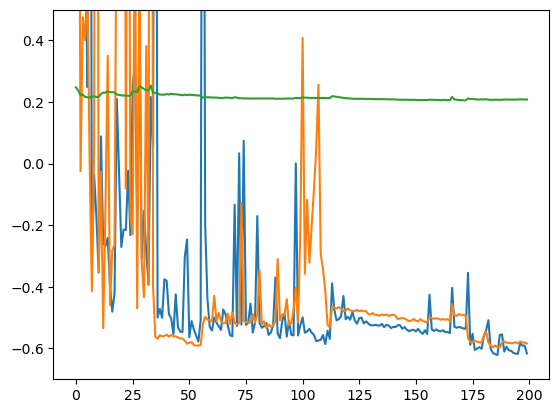

In [233]:
plt.plot(np.array(measures))
plt.ylim(-0.7,0.5)

In [ ]:
class RBFKernel(torch.nn.Module):
    def __init__(self, input_dim):
        super(RBFKernel, self).__init__()
        self.input_dim = input_dim
        self.variance = torch.nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.lengthscale = torch.nn.Parameter(torch.randn(input_dim).abs(), requires_grad=True)

    def forward(self, x1, x2=None):
        # Compute the squared Euclidean distance between x1 and x2
        x1 = x1 / self.lengthscale
        x1s = torch.pow(x1, 2).sum(1)

        if x2 is None: 
            dist = -2 * x1.mm(x1.T) + x1s.view(-1,1) + x1s.view(1,-1)
        else:
            x2 = x2 / self.lengthscale
            x2s = torch.pow(x2, 2).sum(1)
            dist = -2 * x1.mm(x2.T) + x1s.view(-1,1) + x2s.view(1,-1)

        # Compute the kernel matrix
        kernel_matrix = self.variance * torch.exp(-0.5 * dist)

        return kernel_matrix


In [59]:
torch.abs(torch.randn(10))

tensor([1.2797, 0.5692, 0.6242, 1.7780, 0.7217, 0.8491, 0.5731, 0.8418, 0.6193,
        0.3363])

In [76]:
x = torch.rand(256, 91)

In [74]:
def f1(x):
    return torch.pow(torch.cdist(x, x), 2)

def f2(x):
    xs = torch.pow(x, 2).sum(1)
    return -2 * x.mm(x.T) + xs.view(1,-1) + xs.view(-1,1)

%timeit f1(x)
%timeit f2(x)

39.3 µs ± 92 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
23.1 µs ± 31.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
f1(x) - f2(x)

tensor([[ 0.0000e+00, -1.9073e-06, -1.9073e-06,  ...,  1.9073e-06,
         -5.7220e-06,  0.0000e+00],
        [-1.9073e-06,  0.0000e+00, -4.7684e-06,  ..., -1.9073e-06,
          0.0000e+00, -2.8610e-06],
        [-1.9073e-06, -4.7684e-06,  7.6294e-06,  ..., -1.9073e-06,
         -1.9073e-06,  0.0000e+00],
        ...,
        [-1.9073e-06, -1.9073e-06,  1.9073e-06,  ...,  0.0000e+00,
         -1.9073e-06, -1.9073e-06],
        [-5.7220e-06,  0.0000e+00, -1.9073e-06,  ..., -1.9073e-06,
          0.0000e+00,  9.5367e-07],
        [ 0.0000e+00, -2.8610e-06,  0.0000e+00,  ..., -1.9073e-06,
          9.5367e-07,  3.8147e-06]], device='cuda:0')

# check distribution of conditions - temp & time

In [ ]:
from sklearn.manifold import TSNE

tvec = TSNE().fit_transform(feat.numpy())
tx, ty = tvec.T
y1, y2 = label.numpy().T

In [166]:
g1x, g1y, g1z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-150,150,15), np.linspace(-150,150,15), np.linspace(-1,2,15))]
g2x, g2y, g2z = [v.reshape(-1) for v in np.meshgrid(np.linspace(-150,150,15), np.linspace(-150,150,15), np.linspace(-3,2,15))]

In [168]:
import plotly.express as px
g1 = gaussian_kde(np.vstack([tx, ty, y1]))
c1 = g1(np.vstack([g1x, g1y, g1z]))
px.scatter_3d(x=g1x, y=g1y, z=g1z, color=c1, opacity=0.8, size=c1, size_max=40, height=800)

In [170]:
g2 = gaussian_kde(np.vstack([tx, ty, y2]))
c2 = g2(np.vstack([g2x, g2y, g2z]))
px.scatter_3d(x=g2x, y=g2y, z=g2z, color=c2, opacity=0.9, size=c2, size_max=30, height=800)